# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as f
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier, LinearSVC
from sklearn.metrics import confusion_matrix
from functools import reduce
from pyspark.sql.types import IntegerType, DoubleType
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1608810830079'),
 ('spark.driver.host', 'f8b62724ccf2'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '36835')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#load dataset
path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(path)

In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
user_log.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
user_log.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [7]:
# check for number of rows and columns
print('Rows: {}'.format(user_log.count()))
print('Columns: {}'.format(len(user_log.columns)))

Rows: 286500
Columns: 18


In [8]:
# checking for nulls
user_log.select([f.count(when(isnull(c), c)).alias(c) for c in user_log.columns]).toPandas()
# user_log.select([count(when(isnull(c), c)).alias(c) for c in user_log.columns]).show()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [9]:
null_df = user_log.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in user_log.columns))).toPandas()

In [10]:
null_df[null_df['userAgent'].isnull()]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
9,None,Logged Out,None,None,100,None,None,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
10,None,Logged Out,None,None,101,None,None,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
11,None,Logged Out,None,None,102,None,None,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
12,None,Logged Out,None,None,103,None,None,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
16,None,Logged Out,None,None,2,None,None,free,None,GET,Home,NaN,240,None,200,1538356678000,None,
17,None,Logged Out,None,None,3,None,None,free,None,PUT,Login,NaN,240,None,307,1538356679000,None,
26,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,NaN,100,None,307,1538358102000,None,
35,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,NaN,241,None,307,1538360117000,None,
46,None,Logged Out,None,None,14,None,None,free,None,GET,Home,NaN,187,None,200,1538361527000,None,
47,None,Logged Out,None,None,15,None,None,free,None,PUT,Login,NaN,187,None,307,1538361528000,None,


In [11]:
# to understand what kind of users have these null values
null_df['userId'].unique()
# we can see that some normal users and some users without userId ('') fall into this category 

array(['30', '9', '54', '74', '', '4', '101', '78', '88', '95', '25',
       '142', '13', '45', '39', '87', '28', '126', '146', '131', '59',
       '15', '36', '120', '33', '92', '51', '27', '143', '140', '6', '124',
       '141', '93', '81', '40', '94', '98', '113', '137', '65', '42', '53',
       '115', '58', '77', '52', '29', '70', '61', '46', '35', '132', '127',
       '110', '80', '129', '121', '82', '100', '117', '18', '85', '118',
       '105', '96', '38', '20', '55', '12', '41', '3', '73', '17', '136',
       '86', '7', '67', '32', '5', '106', '114', '69', '99', '16', '49',
       '50', '24', '103', '102', '122', '75', '128', '111', '112', '145',
       '66', '83', '44', '11', '91', '37', '90', '104', '138', '148',
       '107', '97', '109', '134', '10', '2', '144', '76', '119', '89',
       '14', '62', '19', '150', '68', '147', '8', '56', '34', '60', '125',
       '133', '47', '26', '43', '57', '149', '64', '21', '71', '108', '79',
       '123', '116', '152', '63', '139', '23'

In [12]:
# what kind of pages were viewed by users without a userId
null_df[null_df['userId']=='']['page'].unique()

array(['Home', 'Help', 'Login', 'About', 'Error', 'Register',
       'Submit Registration'], dtype=object)

In [13]:
# what kind of pages were viewed by users with a userId
null_df[null_df['userId']!='']['page'].unique()

array(['Add to Playlist', 'Roll Advert', 'Thumbs Up', 'Downgrade',
       'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade', 'Add Friend',
       'Settings', 'Submit Upgrade', 'About', 'Submit Downgrade', 'Error',
       'Save Settings', 'Cancel', 'Cancellation Confirmation'], dtype=object)

In [14]:
user_log.select([count(when(col(c)=='', c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8346


In [15]:
# we can see that the users without userId are not needed for our analysis
users_df = user_log.where(user_log.userId != '')
print('Rows: {}'.format(users_df.count()))
print('Columns: {}'.format(len(users_df.columns)))

Rows: 278154
Columns: 18


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
users_df.toPandas().isnull().sum()

artist           50046
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           50046
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             50046
status               0
ts                   0
userAgent            0
userId               0
dtype: int64

In [17]:
users_df.groupby('auth').count().toPandas()

,auth,count
0,Cancelled,52
1,Logged In,278102


In [18]:
users_df.groupby('gender').count().toPandas()

,gender,count
0,F,154578
1,M,123576


In [19]:
users_df.groupby('level').count().toPandas()

,level,count
0,free,55721
1,paid,222433


In [20]:
users_df.groupby('method').count().toPandas()

,method,count
0,PUT,257818
1,GET,20336


In [21]:
users_df.groupby('page').count().orderBy('page').toPandas()

,page,count
0,About,495
1,Add Friend,4277
2,Add to Playlist,6526
3,Cancel,52
4,Cancellation Confirmation,52
5,Downgrade,2055
6,Error,252
7,Help,1454
8,Home,10082
9,Logout,3226


In [22]:
users_df.groupby('status').count().toPandas()

,status,count
0,307,23184
1,404,252
2,200,254718


In [23]:
#create a new column called churn that shows users who visited the cancellation confirmation page as 1 (churned) 
# and those who did not as 0 (not churned)
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
users_df = users_df.withColumn('churn',churn('page'))
# also ensure that instances of churned users display their churned status
churned = users_df.filter(users_df.churn == 1).select('userId').dropDuplicates().rdd.flatMap(lambda x :    x).collect()
users_df = users_df.withColumn('churn', when(col("userId").isin(churned), 1).otherwise(0))

In [24]:
# NB : This does shows the churn proportion for non-unique users
(users_df.groupby("churn").count().select('churn', 'count')
                .toPandas())

,churn,count
0,1,44864
1,0,233290


In [25]:
users_df.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [26]:
users_df.count(), len(users_df.columns)

(278154, 19)

In [27]:
grouped_df = users_df.select("userId", "churn", "gender", "level").toPandas()
distinct_users=grouped_df.drop_duplicates().sort_values(by='userId')
distinct_users

,userId,churn,gender,level
20259,10,0,M,paid
120620,100,0,M,free
4416,100,0,M,paid
207514,100001,1,F,free
209958,100002,0,F,paid
210311,100003,1,F,free
212000,100004,0,F,paid
208455,100004,0,F,free
207634,100005,1,M,free
209210,100006,1,F,free


In [28]:
# number_of_unique_users
unique_users = distinct_users['userId'].nunique()
unique_users

225

Grouping Users by the 'level' column shows us two categories of users:
    * Those who have had only one level (either free or paid since registration)
    * Those who have moved between both levels 

In [29]:
# grouping users by level
levels=distinct_users.groupby(['userId'])['level'].count().rename('number_of_levels').reset_index()
levels['number_of_levels'].unique()
# some users moved from one level to another while some maintained one(as expected)

array([1, 2])

In [30]:
# users with only one kind of level
one = levels[levels['number_of_levels']==1]
one = pd.merge(left=one, right=distinct_users, how='left', on = 'userId')
one.groupby(['level'])['level'].count().rename('counts').reset_index()

,level,counts
0,free,60
1,paid,30


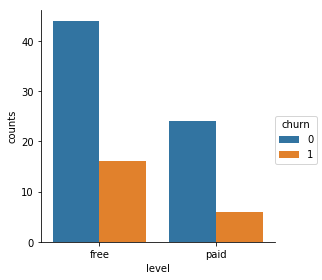

In [31]:
# churn ratio for this group
final = one.groupby(['level', 'churn'])['churn'].count().rename('counts').reset_index()
sns.factorplot(x="level", y="counts", hue="churn", kind="bar", data=final);

In [32]:
# this other group have experienced both levels (free and paid)
two= levels[levels['number_of_levels']!=1]
two['userId'].nunique()

135

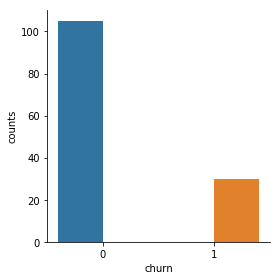

In [33]:
# churn ratio for this group
final = pd.merge(left=two, right=distinct_users[['userId','churn']].drop_duplicates(), how='left', on = 'userId')
final = final.groupby(['churn'])['churn'].count().rename('counts').reset_index()
# # import seaborn as sns
sns.factorplot(x="churn", y="counts", hue="churn", kind="bar", data=final);

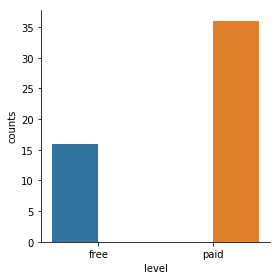

In [34]:
# churn rate by level
first = distinct_users[distinct_users['churn'] == 1]
first = pd.merge(left=first, right=levels, how='left', on='userId')

first.drop(first[(first['number_of_levels'] == 2)&(first['level'] == 'free')].index, inplace = True) 

# # final = pd.merge(left=two, right=distinct_users[['userId','churn']].drop_duplicates(), how='left', on = 'userId')
final = first.groupby(['level'])['level'].count().rename('counts').reset_index()
final

sns.factorplot(x="level", y="counts", hue="level", kind="bar", data=final);

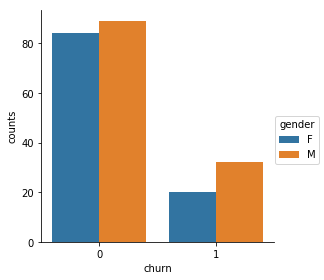

In [35]:
gender = distinct_users[['userId', 'gender', 'churn']].drop_duplicates()
gender=gender.groupby(['gender', 'churn'])['churn'].count().rename('counts').reset_index()
sns.factorplot(x="churn", y="counts", hue="gender", kind="bar", data=gender);

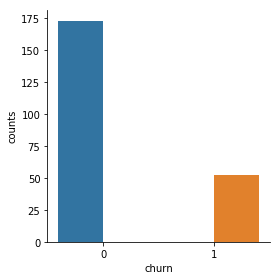

In [36]:
churn = distinct_users[['userId', 'churn']].drop_duplicates()
churn = churn.groupby(['churn'])['churn'].count().rename('counts').reset_index()
sns.factorplot(x="churn", y="counts", hue="churn", kind="bar", data=churn);

In [37]:
# user_log.select("userId").distinct().toPandas()
# user_log.groupBy("userId").count().orderBy('userId').toPandas()

In [38]:
# how many users visited the 'Downgrade' page
dedup_df = users_df.select("userId", "page", "churn").toPandas().drop_duplicates()
dedup_df = dedup_df[dedup_df['page']=='Downgrade']
dedup_df['userId'].nunique()

154

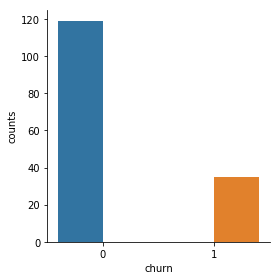

In [39]:
# chart for users who visited the 'Downgrade' page churned
dedup_df = dedup_df.groupby(['churn'])['churn'].count().rename('counts').reset_index()
sns.factorplot(x="churn", y="counts", hue="churn", kind="bar", data=dedup_df);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [40]:
users_df.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [41]:
# dropping irrelevant columns
model_df = users_df.drop('artist', 'auth', 'firstName', 'itemInSession', 'lastName', 'length', 'location', 'method', 'registration', 'sessionId', 'song',
        'userAgent')

In [42]:
model_df.toPandas().head()

,gender,level,page,status,ts,userId,churn
0,M,paid,NextSong,200,1538352117000,30,0
1,M,free,NextSong,200,1538352180000,9,0
2,M,paid,NextSong,200,1538352394000,30,0
3,M,free,NextSong,200,1538352416000,9,0
4,M,paid,NextSong,200,1538352676000,30,0


In [43]:
# build string indexer
gender_indexer = StringIndexer(inputCol='gender', outputCol='indexed_gender')
level_indexer = StringIndexer(inputCol='level', outputCol='indexed_level')
page_indexer = StringIndexer(inputCol="page", outputCol='indexed_page')
indexer = StringIndexer(inputCol="churn", outputCol="label")

# model_df = gender_indexer.fit(model_df).transform(model_df)
# model_df = level_indexer.fit(model_df).transform(model_df)
# model_df = page_indexer.fit(model_df).transform(model_df)
# model_df = indexer.fit(model_df).transform(model_df)

In [44]:
# vectorize all features
assembler  = VectorAssembler(inputCols = ["indexed_gender", "indexed_level", "indexed_page", "status", "ts"], 
                             outputCol = "input_variables")
# model_df = assembler.transform(model_df)

In [45]:
# scale features
scaler_q3 = MinMaxScaler(inputCol="input_variables", outputCol="Scaled_features")
# scaler= scaler_q3.fit(model_df)
# model_df = scaler.transform(model_df)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [46]:
train, test = model_df.randomSplit([0.8, 0.2], seed = 42)

In [47]:
model_df.groupby("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



In [48]:
train.groupby("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 35991|
|    0|186989|
+-----+------+



In [49]:
test.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1| 8873|
|    0|46301|
+-----+-----+



In [50]:
def evaluate_model(model, metric, data, start, end):
    #predictions
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(data)
    
    #f1 score
    score = evaluator.evaluate(predictions)
    print('F1 score:', score)
    print('Total training time: {} seconds'.format(end - start))

In [51]:
# Random Forest Model.
rf = RandomForestClassifier(labelCol="label", featuresCol="Scaled_features", numTrees=10)

param_grid = ParamGridBuilder() \
            .addGrid(rf.impurity,['entropy', 'gini']) \
            .addGrid(rf.maxDepth,[5, 10]) \
            .addGrid(rf.seed, [42]).build()

pipeline = Pipeline(stages=[indexer, level_indexer, page_indexer, gender_indexer, assembler, scaler_q3, rf])

rf_cv = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)
start = time()
rf_model = rf_cv.fit(train)
end = time()
evaluate_model(rf_model, 'f1', test, start, end)

F1 score: 0.8057329867369252
Total training time: 188.18972396850586 seconds


In [53]:
svm = LinearSVC(labelCol="label", featuresCol="Scaled_features")

paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 20]) \
    .build()

pipeline = Pipeline(stages=[indexer, level_indexer, page_indexer, gender_indexer, assembler, scaler_q3, svm])

svm_cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=MulticlassClassificationEvaluator(), numFolds = 2)
start = time()
svm_model = svm_cv.fit(train)
end= time()
evaluate_model(svm_model, 'f1', test, start, end)

F1 score: 0.7658032532845784
Total training time: 209.59195184707642 seconds


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.